# Introduction to Quantum Computing

## Table of contents

* ### [Installing and importing libraries](#imports)

    - [Install Qibo](#installqibo)
    - [Check version](#version)

* ### [Quantum circuits in Qibo](#quantumcircuits)

    - [Executing circuits using full state vectors](#basicexecution)
    - [Circuit summary](#summary)
    - [Writing a Quantum Fourier Transform](#basicqft)
    - [Performing measurements](#measurements)

* ### [Variational optimization applications](#variationalapplications)

    - [Variational Quantum Eigensolver (VQE)](#vqeapplication)

<a name="imports"></a>
## Installing and importing libraries

<a name="installqibo"></a>
### Install Qibo

This step is required only when using Colab or an environment in which Qibo is not already installed.

In [ ]:
!pip install qibo

<a name="version"></a>
### Check version

Check Qibo and Python version

In [ ]:
import sys, qibo
print("Python version:", sys.version)
print("Qibo version:", qibo.__version__)

In [ ]:
from qibo import gates, models, hamiltonians
import numpy as np
import matplotlib.pyplot as plt

<a name="quantumcircuits"></a>
## Quantum circuits in Qibo

We will start this tutorial focusing on the circuit-based model of quantum computation.

The main Python object used for the classical simulation of quantum circuits is `qibo.models.Circuit`. 
A circuit has a predefined number of qubits and holds a list of gates (`qibo.gates.Gate` objects) that can act on these qubits.

<a name="basicexecution"></a>
### Executing circuits using state vectors

Let's create a circuit with two qubits and add a Hadamard gate on each qubit
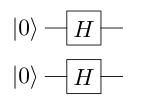

In [ ]:
circuit = models.Circuit(2)
circuit.add(gates.H(0))
circuit.add(gates.H(1))

The circuit can be visualized with

In [ ]:
print(circuit.draw())

The circuit can be executed as follows

In [ ]:
final_state = circuit()
print(final_state.state())

In this case the default initial state $\left | 00\dots 0\right \rangle $ is used. Here this is transformed to $\left | ++\dots +\right \rangle $ which corresponds to the printed vector (in the computational basis).

The user may use a different initial state by calling the circuit on the corresponding state vector. For example acting with the above circuit on the $\left | ++\dots +\right \rangle $ will transform it back to $\left | 00\dots 0\right \rangle $:

In [ ]:
final_state = circuit(np.ones(4) / 2.0)
print(final_state.state())

<a name="summary"></a>
### Circuit summary

We can can print useful information about the circuit using `circuit.summary`:

In [ ]:
print(circuit.summary())

In [ ]:
print(circuit.to_qasm())

<a name="basicqft"></a>
### Writing a Quantum Fourier Transform

Because of its importance on many quantum algorithms, the circuit that implements the [Quantum Fourier Transform (QFT)](https://en.wikipedia.org/wiki/Quantum_Fourier_transform) is coded as a built-in Qibo model.

In [ ]:
qft = models.QFT(4)
print(qft.draw())

In [ ]:
final_state = qft()
print(final_state.state())

In [ ]:
print(qft.summary())

<a name="measurements"></a>
### Performing measurements

In the previous example we showed how circuits are simulated using the full state vectors (wave function). In real implementations this information is not accessible and we should rely on measurements. Qibo simulates measurements using the measurement gate `gates.M` and passing the number of shots when executing circuits.

Let's create and measure a circuit of two qubits containing an $R_Y$ rotation on each qubit:

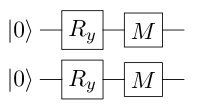

In [ ]:
circuit = models.Circuit(2)
circuit.add(gates.RY(0, theta=np.pi / 3))
circuit.add(gates.RY(1, theta=np.pi / 2))
circuit.add(gates.M(0))
circuit.add(gates.M(1))

shots = circuit(nshots=1000)

This object contains the outcomes of the measurement shots, which can be viewed as raw samples:

In [ ]:
shots.samples(binary=True)

or via their frequencies:

In [ ]:
shots.frequencies()

The latter can be plotted in a histogram

In [ ]:
labels, values = zip(*shots.frequencies().items())

plt.figure(figsize=(7, 4))
plt.bar(labels, values, width=0.4)
plt.show()

<a name="variationalapplications"></a>
## Variational optimization applications



<a name="vqeapplication"></a>
### Variational Quantum Eigensolver (VQE)

Qibo provides functionality to optimize a Variational Eigensolver. This includes a VQE model that handles optimization and Hamiltonians which can be used to define the loss function. In the following example we optimize a VQE to find the ground state of the Heisenberg XXZ model

$$H = \sum _{i = 1}^N \left (X_i X_{i + 1} + Y_i Y_{i + 1} + \delta Z_i Z_{i + 1}\right )$$

We use the variational circuit from the "Using parametrized gates" example as our VQE ansatz. For better performance on large `nqubits` one may use the `VariationalLayer` gate, instead of standard `RY` and `CZ` gates to define this circuit. This fuses each `CZ` gate with the neighboring `RY` gates, as shown in the figure:

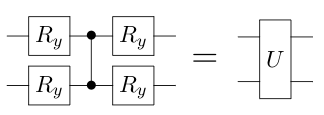

In [ ]:
nqubits = 4 # number of qubits in the system
nlayers = 2 # number of layers in the circuit ansatz

# Define problem Hamiltonian
hamiltonian = hamiltonians.XXZ(nqubits)

# Define variational circuit ansatz
circuit = models.Circuit(nqubits)
pairs = list((i, i + 1) for i in range(0, nqubits - 1, 2))
for l in range(nlayers):
    circuit.add(gates.VariationalLayer(range(nqubits), pairs,
                                       gates.RY, gates.CZ,
                                       np.zeros(nqubits),
                                       np.zeros(nqubits)))
    circuit.add((gates.CZ(i, i + 1) for i in range(1, nqubits - 2, 2)))
    circuit.add(gates.CZ(0, nqubits - 1)) 
circuit.add((gates.RY(i, theta=0) for i in range(nqubits)))

# Define VQE model
vqe = models.VQE(circuit, hamiltonian)

In [ ]:
# Calculate exact ground state energy using exact diagonalization
target_energy = np.real(np.min(hamiltonian.eigenvalues()))

# Optimize the VQE model
initial_parameters = np.random.uniform(0, 2 * np.pi, 2 * nqubits * nlayers + nqubits)
best_energy, params, extra = vqe.minimize(initial_parameters, method="BFGS", 
                                   options={'disp': True, "maxiter": 100}, 
                                   compile=False)

print()
print("Target energy:", target_energy)
print("Minimum energy obtained:", best_energy)